In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import osmnx as ox
import pandas as pd
import pickle
import tensorflow as tf

In [2]:
tf.__version__

'1.12.0'

In [3]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

## Load the model
Load the training supposed best training checkpoint. Then put the weight into a newly generated model that can handel a single batch.

In [4]:
DATASET_NAME = 'cabspotting'
GRU_SIZE = 32
setup_string = 'GRU-{gru_size}_TD-Dense-3_{dataset}_64_100_adam_mae_default'.format(dataset=DATASET_NAME,
                                                                                    gru_size=GRU_SIZE)

In [5]:
setup_string

'GRU-32_TD-Dense-3_cabspotting_64_100_adam_mae_default'

In [6]:
history = pickle.load(open('histories/citybased_rnn_2/' + setup_string + '_30.pkl', 'rb'))

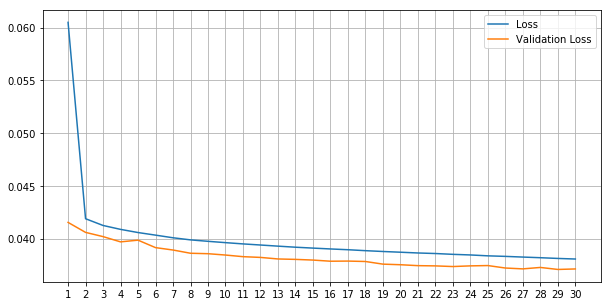

In [7]:
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, 31, 1), history['loss'], label='Loss')
plt.plot(np.arange(1, 31, 1), history['val_loss'], label='Validation Loss')
plt.xticks(np.arange(1, 31, 1))
plt.grid()
plt.legend()
plt.show()

In [8]:
SELECTED_EPOCH = 30

In [9]:
# Load the model
model_path = 'checkpoints/citybased_rnn_2/' + setup_string + '_{:02}.h5'.format(SELECTED_EPOCH)
loaded_model = tf.keras.models.load_model(model_path)

In [10]:
def build_model(batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(GRU_SIZE, return_sequences=True, stateful=True, input_shape=(None, 3), batch_size=batch_size),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(3))
    ])
    return model

In [11]:
model = build_model(batch_size=1)
model.set_weights(loaded_model.get_weights())

## Actual generation

In [12]:
N_USERS = 8

Generate user start positions

In [13]:
poskde = pickle.load(open('../data_{dataset}/poskde_{dataset}_000003.pkl'.format(dataset=DATASET_NAME), 'rb'))

In [14]:
startpositions = poskde.sample(N_USERS)

In [15]:
startpositions[:3]

array([[-122.42578842,   37.78725969],
       [-122.41717597,   37.78827358],
       [-122.43637265,   37.79968725]])

Generate start and end times

In [16]:
BEGIN = pd.Timestamp('2008-05-17 10:00:04')
END = pd.Timestamp('2008-06-10 09:25:34')
#END = pd.Timestamp('2008-05-19 09:25:34')
total_duration = END - BEGIN

In [17]:
total_duration

Timedelta('23 days 23:25:30')

In [18]:
sekde = pickle.load(open('../data_{dataset}/sekde_{dataset}_003.pkl'.format(dataset=DATASET_NAME), 'rb'))

In [19]:
starttimes = np.full(N_USERS, -1.0)
out_of_range = (starttimes < 0) | (starttimes >= 1.0)

while np.any(out_of_range):
    new_samples = np.squeeze(sekde['kde_start'].sample(len(starttimes[out_of_range])))
    starttimes[out_of_range] = new_samples
    out_of_range = (starttimes < 0) | (starttimes >= 1.0)

In [20]:
starttimes[:3]

array([0.76943673, 0.00655357, 0.81900751])

In [21]:
durations = np.zeros(N_USERS)
out_of_range = (durations <= 0) | (starttimes + durations > 1.0)

while np.any(out_of_range):
    new_samples = np.squeeze(sekde['kde_duration'].sample(len(durations[out_of_range])))
    durations[out_of_range] = new_samples
    out_of_range = (durations <= 0) | (starttimes + durations > 1.0)

In [22]:
durations[:3]

array([0.2262573 , 0.98400173, 0.01031957])

In [23]:
starttimes = starttimes * total_duration.total_seconds()
starttimes[:3]

array([1593911.26678141,   13575.90942657, 1696598.61716401])

In [24]:
durations = durations * total_duration.total_seconds()
durations[:3]

array([ 468698.77819515, 2038389.11158451,   21377.28990395])

In [25]:
starts = np.concatenate([starttimes.reshape(-1, 1), startpositions], axis=1)

In [26]:
starts[:3]

array([[ 1.59391127e+06, -1.22425788e+02,  3.77872597e+01],
       [ 1.35759094e+04, -1.22417176e+02,  3.77882736e+01],
       [ 1.69659862e+06, -1.22436373e+02,  3.77996873e+01]])

In [27]:
scaler = pickle.load(open('scalers/citybased_rnn_2/' + setup_string + '.pkl', 'rb'))

/Users/jankaiser/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


Actual generation loops

In [28]:
one_second = scaler.transform(np.array([[1.0, 0.0, 0.0]]))[0, 0]
one_second

-0.05485318227960303

In [29]:
def generate_user(generator, scaler, start, duration):
    generator.reset_states()
    s = scaler.transform(np.array([start]).astype(np.float32))
    sc = np.array([start])
    
    starttime = start[0]
    endtime = starttime + duration
    
    while(sc[-1][0] <= endtime):
        x = s[-1:]
        x = np.array([x])
        
        y = model.predict(x, batch_size=1)
        
        y = np.squeeze(y, axis=0)
        y[0, 0] = max(one_second, y[0, 0])
        s = np.concatenate([s, y])
        
        yc = np.squeeze(scaler.inverse_transform(np.array([y])))
        yc[0] = sc[-1][0] + yc[0]
        yc = np.array([yc])
        sc = np.concatenate([s, yc])
    
    return sc[:-1]

In [30]:
data = []
for u in range(N_USERS):
    print(u)
    s = generate_user(model, scaler, starts[u], durations[u])
    data.append(s)

0
1
2
3
4
5
6
7


Convert data to standard format

In [31]:
data[0]

array([[ 9.62260864e+02, -3.74554753e-01,  4.44232613e-01],
       [ 1.97503939e-02, -5.29070377e-01, -3.36866260e-01],
       [ 1.08382115e-02, -8.08189452e-01, -4.39945310e-01],
       ...,
       [-1.37611455e-03, -2.09872723e+00,  4.69980049e+00],
       [-1.37611455e-03, -2.09872723e+00,  4.69980049e+00],
       [-1.37611455e-03, -2.09872723e+00,  4.69980049e+00]], dtype=float32)

In [40]:
data[i][:, 0].tolist()

[8.140933990478516,
 -0.024406129494309425,
 0.00029460954829119146,
 -0.008071597665548325,
 -0.013834484852850437,
 -0.016553213819861412,
 -0.017889240756630898,
 -0.018582118675112724,
 -0.018930546939373016,
 -0.0190920140594244,
 -0.01915580779314041,
 -0.019170593470335007,
 -0.01916213147342205,
 -0.019143937155604362,
 -0.01912294700741768,
 -0.01910252682864666,
 -0.019084103405475616,
 -0.019068125635385513,
 -0.019054584205150604,
 -0.0190433319658041,
 -0.019034164026379585,
 -0.019026925787329674,
 -0.019021520391106606,
 -0.019017893821001053,
 -0.01901605911552906,
 -0.019016114994883537,
 -0.019018180668354034,
 -0.019022492691874504,
 -0.01902935281395912,
 -0.019039178267121315,
 -0.019052565097808838,
 -0.019070282578468323,
 -0.019093265756964684,
 -0.019122814759612083,
 -0.01916041597723961,
 -0.01920757070183754,
 -0.01926538534462452,
 -0.01933329738676548,
 -0.01940711960196495,
 -0.019481198862195015,
 -0.01954217627644539,
 -0.01953059807419777,
 -0.01934653

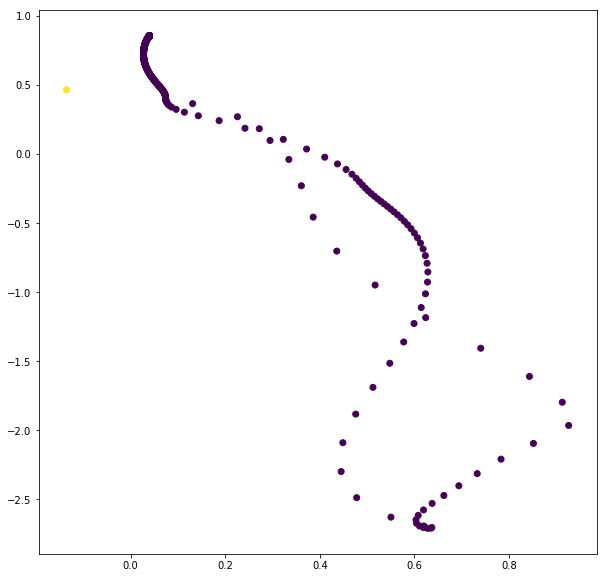

In [38]:
i = 1
plt.figure(figsize=(10, 10))
plt.scatter(data[i][:, 1], data[i][:, 2], c=data[i][:, 0])